# Data exploration

#### Data set from : https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation

The data was obtained from The Cancer Genome Atlas (TCGA) and The Cancer Imaging Archive (TCIA). \
A group of **110** patients  who had preoperative imaging data available, containing at least a fluid-attenuated inversion recovery
(FLAIR) sequence was from the following 5 institutions: 

1. Thomas Jefferson University (TCGA-CS, **16 patients**) 
2. Henry Ford Hospital (TCGA-DU, **45 patients**)
3. UNC(TCGA-EZ, **1 patient**)
4. Case Western (TCGA-FG, **14 patients**)
5. Case Western – St. Joseph’s (TCGA-HT, **34 patients**)  

This dataset contains **brain MR images** together with manual FLAIR abnormality segmentation **masks**. Masks are binary, 1-channel images.

Each patient has several brain MR images that represent different brain slices ,The number of slices varied among patients from **20** to **88**.


In total this data set contains **3 929** MR images with their corresponding masks.


#### 1: IMPORTING LIBRARIES

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import glob
import random
import config
conf = config.Config()


#### 2: IMPORTING DATASET

The `data.csv` file contains Tumor genomic clusters and patient data .

In [4]:
data = pd.read_csv(os.path.join(conf.KAGGLE_3M_DATASET_DIR , "data.csv"))
data.head(10)

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0
5,TCGA_CS_5395,2.0,4.0,2,2.0,NaN,3.0,2,3.0,1.0,1.0,3.0,5.0,2.0,43.0,2.0,NaN,1.0
6,TCGA_CS_5396,3.0,3.0,2,3.0,2.0,2.0,3,3.0,2.0,1.0,3.0,2.0,1.0,53.0,3.0,2.0,0.0
7,TCGA_CS_5397,NaN,4.0,1,2.0,3.0,3.0,2,1.0,2.0,1.0,1.0,6.0,1.0,54.0,3.0,2.0,1.0
8,TCGA_CS_6186,2.0,4.0,1,2.0,1.0,3.0,2,2.0,2.0,1.0,3.0,2.0,2.0,58.0,3.0,2.0,1.0
9,TCGA_CS_6188,2.0,4.0,3,2.0,3.0,3.0,2,1.0,2.0,1.0,3.0,6.0,2.0,48.0,3.0,2.0,0.0


Now we will map every image to its patient_id

In [6]:
data_map = []
for sub_dir_path in glob.glob(os.path.join(conf.KAGGLE_3M_DATASET_DIR , "*")):
    try:
        dir_name = os.path.basename(sub_dir_path)
        for filename in os.listdir(sub_dir_path):
            image_path = os.path.join(sub_dir_path ,filename)
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)


[Errno 20] Not a directory: '/root/test01/src/data/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/root/test01/src/data/lgg-mri-segmentation/kaggle_3m/data.csv'


In [9]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

,patient_id,path
0,TCGA_CS_5396_20010302,/root/test01/src/data/lgg-mri-segmentation/kag...
1,TCGA_CS_5396_20010302,/root/test01/src/data/lgg-mri-segmentation/kag...
2,TCGA_CS_5396_20010302,/root/test01/src/data/lgg-mri-segmentation/kag...
3,TCGA_CS_5396_20010302,/root/test01/src/data/lgg-mri-segmentation/kag...
4,TCGA_CS_5396_20010302,/root/test01/src/data/lgg-mri-segmentation/kag...


In [10]:
df_MR_images = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]



**df_MR_images** and **df_masks** contain respectively the paths of MR images and the masks 

In [11]:
df_MR_images.describe()
#df_masks.describe()

,patient_id,path
count,3929,3929
unique,110,3929
top,TCGA_HT_A61A_20000127,/root/test01/src/data/lgg-mri-segmentation/kag...
freq,88,1


In total this data set contains 3 929 MR images with its corresponding masks from the data of 110 patients.\
One patient have a maximum of **88** Brain slices ( MR images)

#### 3: CREATING THE FINAL DATASET


In [15]:
# File path line length to later delete the suffix for sorting
BASE_LEN = len(os.path.basename(df_MR_images["path"].values[0]))
END_IMG_LEN = 4 # len(.tif)
END_MASK_LEN = 9 # (_mask.tif)

# Data sorting
# we try to delete the suffix of the file names.

imgs = sorted(df_MR_images["path"].values, key=lambda x : x[BASE_LEN:-END_IMG_LEN])
masks = sorted(df_masks["path"].values, key=lambda x : x[BASE_LEN:-END_MASK_LEN])



# Final Data
brain_df = pd.DataFrame({
                         "image_path": imgs,
                         "mask_path": masks
                        })

def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df.head(10)

,image_path,mask_path,mask
0,/root/test01/src/data/lgg-mri-segmentation/kag...,/root/test01/src/data/lgg-mri-segmentation/kag...,0
1,/root/test01/src/data/lgg-mri-segmentation/kag...,/root/test01/src/data/lgg-mri-segmentation/kag...,0
2,/root/test01/src/data/lgg-mri-segmentation/kag...,/root/test01/src/data/lgg-mri-segmentation/kag...,1
3,/root/test01/src/data/lgg-mri-segmentation/kag...,/root/test01/src/data/lgg-mri-segmentation/kag...,1
4,/root/test01/src/data/lgg-mri-segmentation/kag...,/root/test01/src/data/lgg-mri-segmentation/kag...,1
5,/root/test01/src/data/lgg-mri-segmentation/kag...,/root/test01/src/data/lgg-mri-segmentation/kag...,1
6,/root/test01/src/data/lgg-mri-segmentation/kag...,/root/test01/src/data/lgg-mri-segmentation/kag...,1
7,/root/test01/src/data/lgg-mri-segmentation/kag...,/root/test01/src/data/lgg-mri-segmentation/kag...,1
8,/root/test01/src/data/lgg-mri-segmentation/kag...,/root/test01/src/data/lgg-mri-segmentation/kag...,1
9,/root/test01/src/data/lgg-mri-segmentation/kag...,/root/test01/src/data/lgg-mri-segmentation/kag...,1


#### 4: DATA VISUALISATION

In [16]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

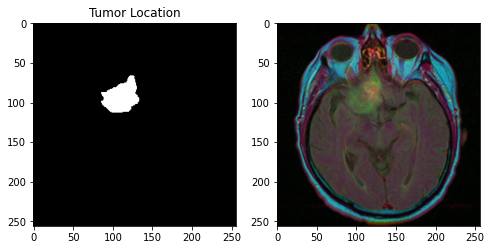

In [17]:
#Plot of an expl when there is a tumor on the MR image

for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));

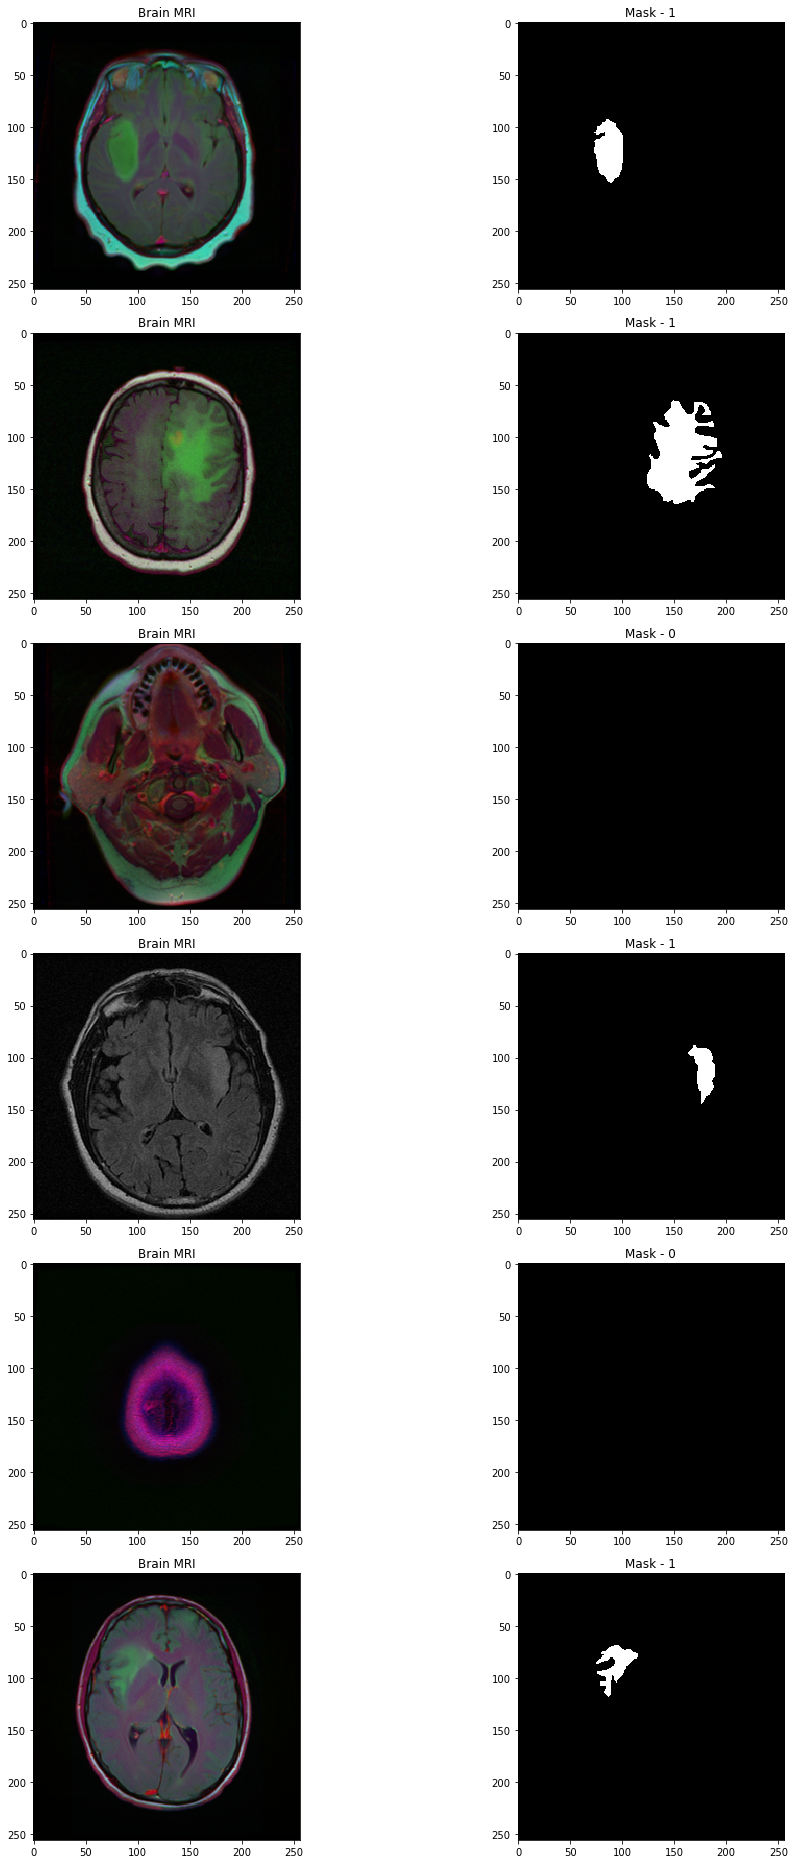

In [36]:
#plot of several expls of MR images with their corresponding mask (mask-1 if the tumor exists)

fig, axs = plt.subplots(6,2, figsize=(16,26))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

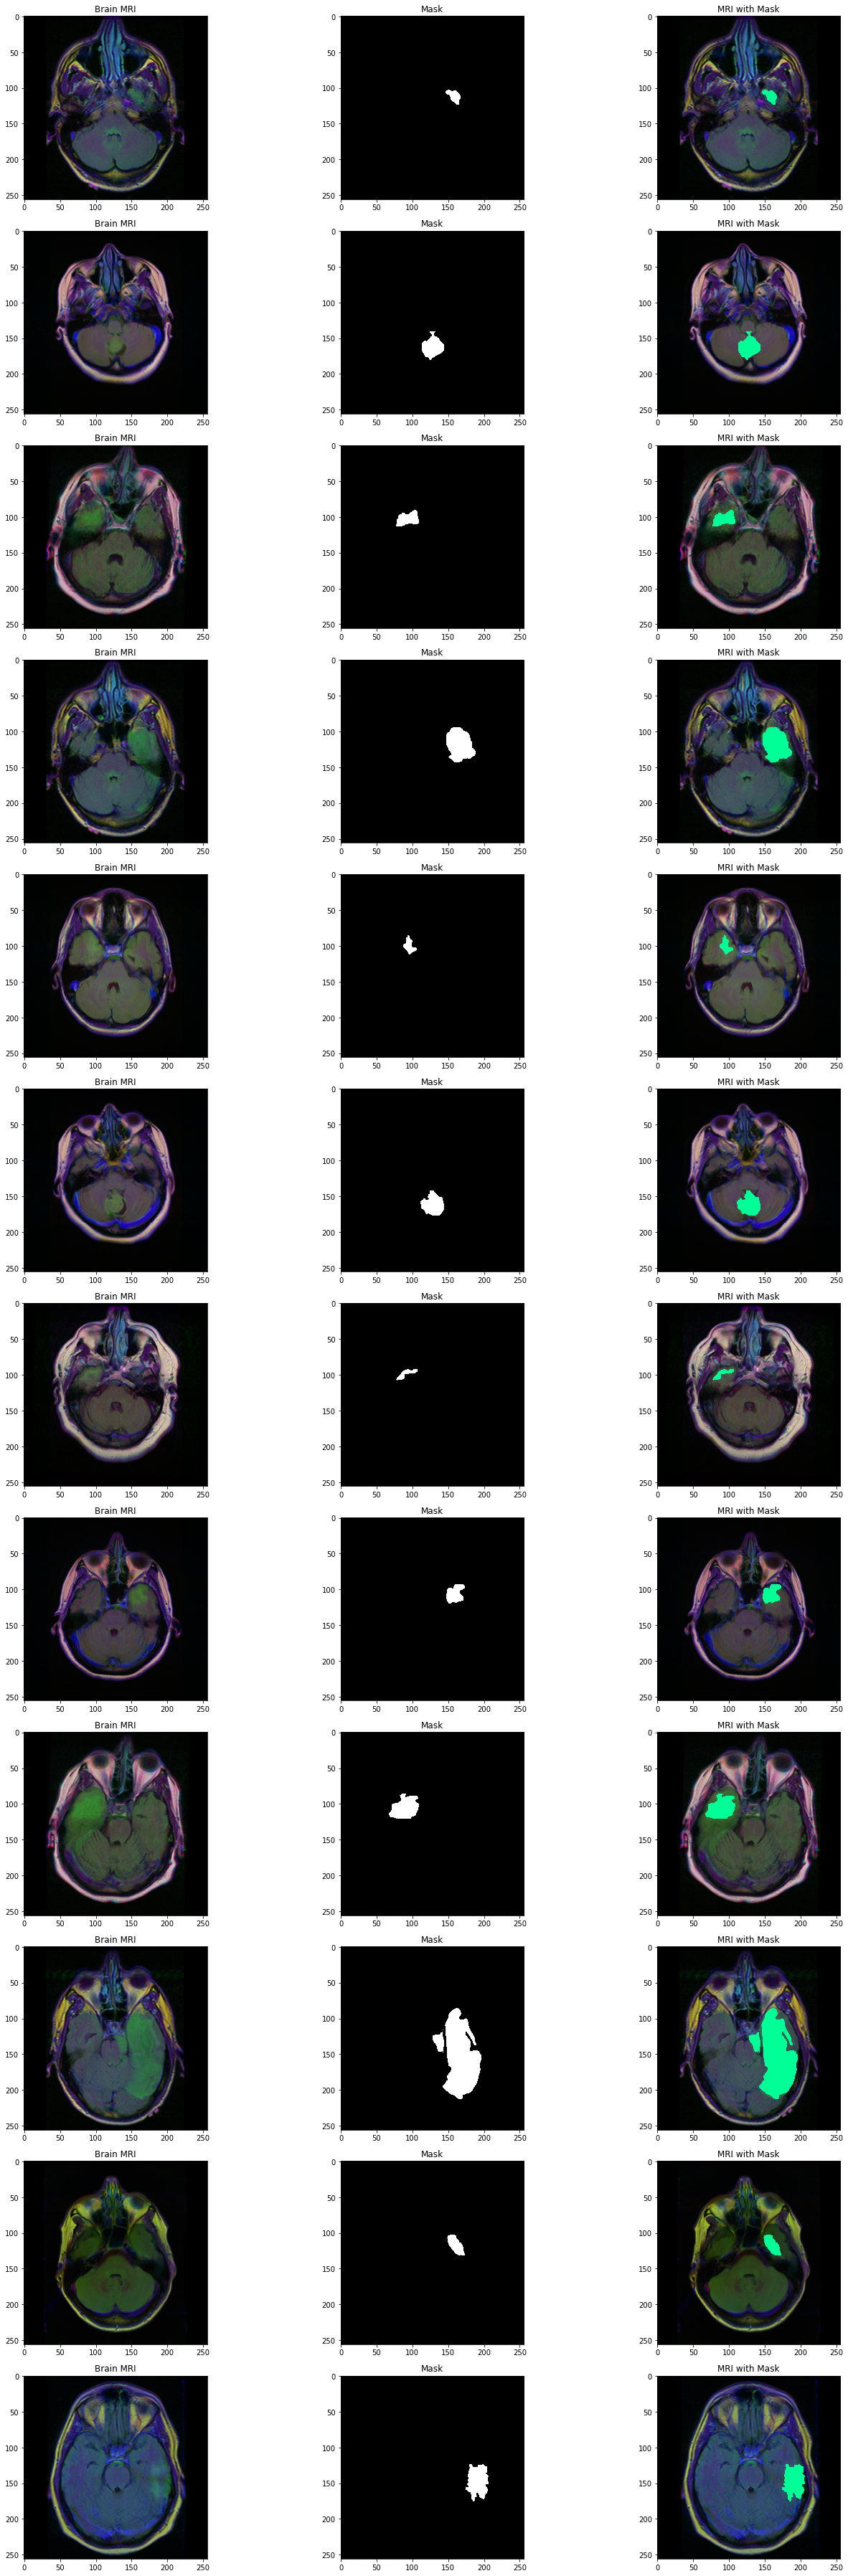

In [37]:
#highlighting the tumor zones on the MR images

count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (0,255,150)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break
        
fig.tight_layout()